## 7. Advanced segmentation and meshing

The first step in the tissue cartography pipeline is the creation of a 3d segmentation of your object of interest. So far, we have used ilastik's pixel classifier to do this. However, this may not always work:

1. Your data is too noisy/complicated so that with a pixel classification alone it is not possible to get a good segmentation of your object (e.g. the segmentation based on pixel classification has holes/gaps)
2. You have a segmentation of the _outline_/_edge_ of your object and need to convert that into a "solid" segmentation

Here, we first show how you can adress this issue using the [`morphsnakes` package](https://github.com/pmneila/morphsnakes). This algorithm essentially works by computationally "inflating a balloon" at a seed point, with the ilastik probability output acting as a barrier. See this example, with the "balloon" in blue:

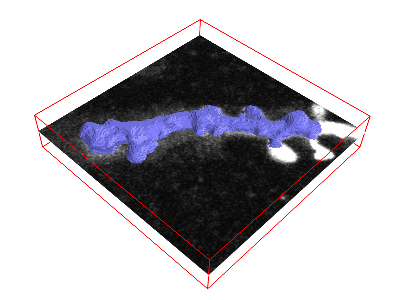

With the resulting solid segmentation in hand, you can create a triangular mesh using the marching cubes algorithm as before.

### Surface reconstruction from a point set

However, this will not always work. What if the surface you are interested in is not the boundary of a solid volume (for example, a floating membrane with perforations)? In this case, we recommend the following:
1. Obtain a set of points on your surface
2. From the point cloud, create a mesh using the Poisson reconstruction algorithm.

These two algorithms are implemented in `pymeshlab`, and we'll show you how to use them below.

In [ ]:
from blender_tissue_cartography import io as tcio
from blender_tissue_cartography import mesh as tcmesh
from blender_tissue_cartography import remesh as tcremesh
from blender_tissue_cartography import interpolation as tcinterp
from blender_tissue_cartography import registration as tcreg
from blender_tissue_cartography import morphsnakes

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from skimage import transform
from scipy import ndimage
import os
import igl

In [ ]:
# this module will not be available on new ARM apple computers

import pymeshlab
from blender_tissue_cartography import interface_pymeshlab as intmsl
from blender_tissue_cartography import remesh_pymeshlab as tcremesh_pymeshlab

Unable to load the following plugins:

	libio_e57.so: libio_e57.so does not seem to be a Qt Plugin.

Cannot load library /home/nikolas/Programs/miniconda3/envs/blender-tissue-cartography/lib/python3.11/site-packages/pymeshlab/lib/plugins/libio_e57.so: (/lib/x86_64-linux-gnu/libp11-kit.so.0: undefined symbol: ffi_type_pointer, version LIBFFI_BASE_7.0)



### Morphsnakes to convert boundary into volume segmentation

Let's see how to use morphsnakes to convert a segmentation of a surface _boundary_ into a volumetric segmentation.
Let's consider the example of the zebrafish egg from the previous tutorial. The fluorescently marked nuclei surround a dark yolk which is not very different from the outside of the image:

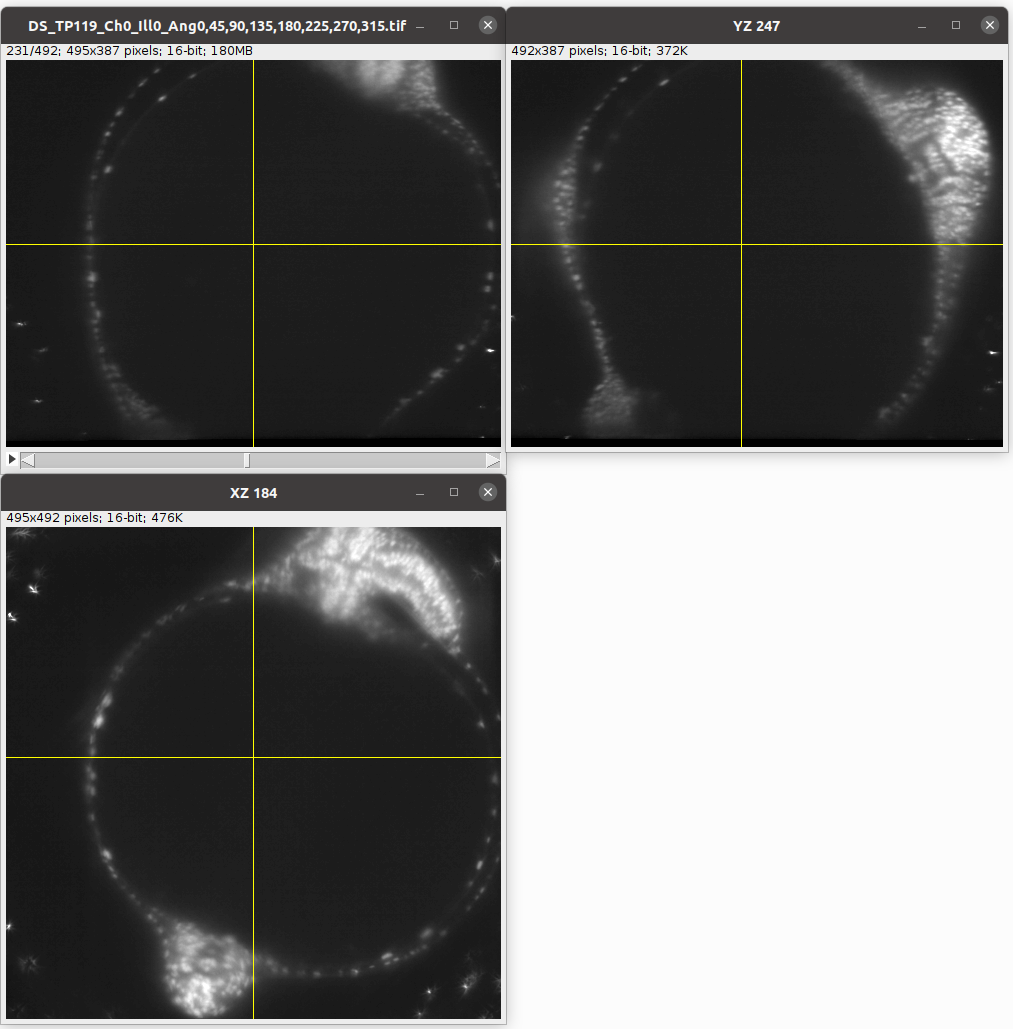
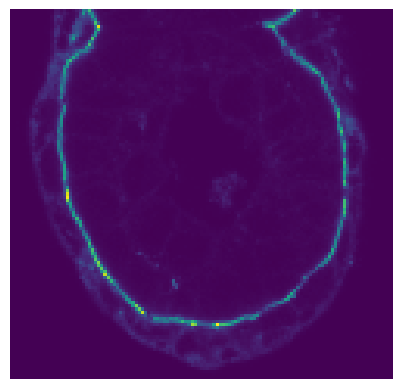

### Create 3d segmentation

Now we create a 3d segmentation, in this case using ilatik. As before, we use [ilastik binary pixel classification](https://www.ilastik.org/documentation/pixelclassification/pixelclassification). When classifying the data in ilastik, we take care that there are no "holes" in the shell we are segmenting out. We will then use [morphsnakes](https://github.com/pmneila/morphsnakes) for post-processing: we need to fill in the "hollow shell" resulting from the ilastik segmentation. We then load the segmentation back into the jupyter notebook.

**Note**: for this tutorial, only the ilastik segmentation data is included.

In [ ]:
# After creating an ilastik project, training the model, and exporting the probabilities, we load the segmentation
# make sure you put in the right name for the ilastik output file 

segmentation = tcio.read_h5(f"reconstruction_example/zebrafish_probabilities.h5")
segmentation = segmentation[0] # Select the first channel of the segmentation - it's the probability a pixel is part of the sample
segmentation = segmentation[::2, ::2, ::2] # to run this tutorial a little faster, we subsample by 2x

print("segmentation shape:", segmentation.shape)

segmentation shape: (82, 65, 83)


<matplotlib.image.AxesImage>

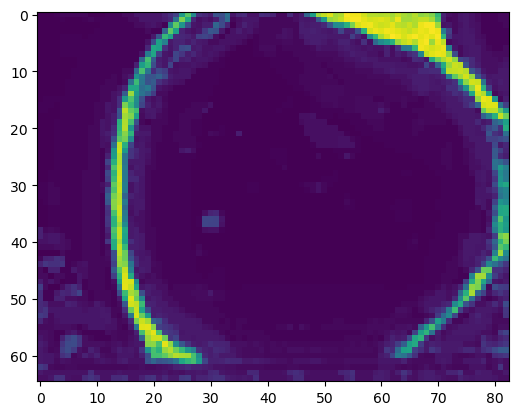

In [ ]:
# look at the segmentation in a cross section

plt.imshow(segmentation[40,:,:], vmin=0, vmax=1)

### Filling the segmentation using morphsnakes

In [ ]:
# we create an initial "seed" for the segmentation, which is 1 in the inside of the embryo

seed_level_set = np.zeros_like(segmentation)
print("segmentation shape:", seed_level_set.shape, f"image center approximately at {np.array(seed_level_set.shape)/2}")

cube_size = 10
seed_level_set[40-cube_size:40+cube_size, 30-cube_size:30+cube_size, 45-cube_size:45+cube_size] = 1


segmentation shape: (82, 65, 83) image center approximately at [41.  32.5 41.5]


<matplotlib.image.AxesImage>

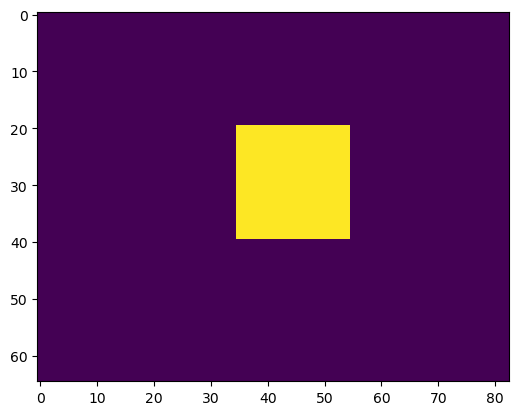

In [ ]:
plt.imshow(seed_level_set[40,:,:], vmin=0, vmax=1)

In [ ]:
help(morphsnakes.morphological_chan_vese)

Help on function morphological_chan_vese in module blender_tissue_cartography.morphsnakes:

morphological_chan_vese(image, iterations, init_level_set='checkerboard', smoothing=1, lambda1=1, lambda2=1, iter_callback=<function <lambda>>)
    Morphological Active Contours without Edges (MorphACWE)
    
    Active contours without edges implemented with morphological operators. It
    can be used to segment objects in images and volumes without well defined
    borders. It is required that the inside of the object looks different on
    average than the outside (i.e., the inner area of the object should be
    darker or lighter than the outer area on average).
    
    Parameters
    ----------
    image : (M, N) or (L, M, N) array
        Grayscale image or volume to be segmented.
    iterations : uint
        Number of iterations to run
    init_level_set : str, (M, N) array, or (L, M, N) array
        Initial level set. If an array is given, it will be binarized and used
        as the 

We neeed the `lambda1`-parameter of `morphsnakes.morphological_chan_vese` to be larger than the `lambda2`-parameter, since we want to segment out the "inside". 

**Warning** for big volumetric images, `morphsnakes` can take a long time. In doubt, increase downsampling.

In [ ]:
%%time
segmentation_filled = morphsnakes.morphological_chan_vese(segmentation, iterations=100,
                                                          init_level_set=seed_level_set,
                                                          lambda1=2, lambda2=1, smoothing=3)

CPU times: user 13.5 s, sys: 587 μs, total: 13.5 s
Wall time: 13.5 s


In [ ]:
# we may want to expand the segmentation a little

segmentation_filled_expanded = ndimage.binary_dilation(segmentation_filled, iterations=1).astype(np.uint8)

<matplotlib.contour.QuadContourSet>

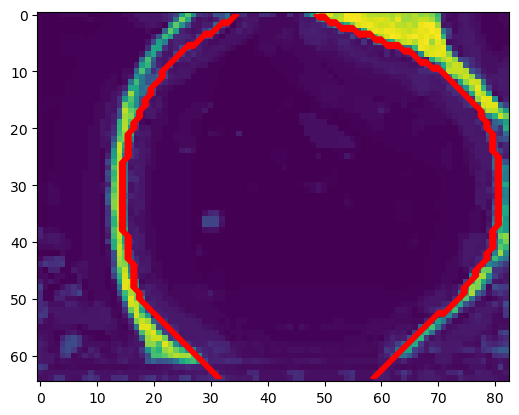

In [ ]:
# we use a contour plot to check that our segmentation matches the data

zslice = 40

plt.imshow(segmentation[zslice,:,:])
plt.contour(segmentation_filled_expanded[zslice,:,:], colors=["r"])

Important: the resulting segmentation will give us a mesh of the _inner_ surface of the fish embryo. The outer surface at this stage is already a lot more complicated due to the fish's body developing on top of the egg:

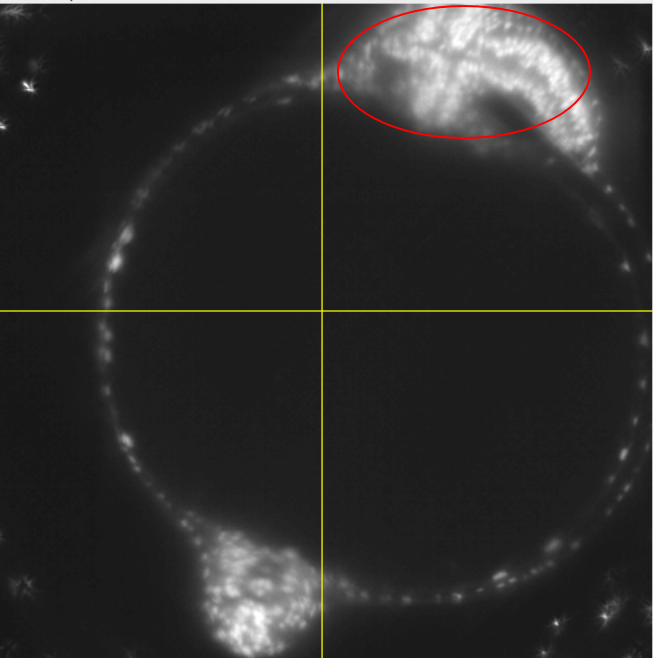

## Meshing

We convert the segmentation into a triangular mesh using the marching cubes method, as before.

**Important convention** For sanity's sake, we will always store all mesh coordinates in microns. This means rescaling appropriately after calculating the mesh from the 3d segmentation.

In [ ]:
metadata_dict = {'resolution_in_microns': (1, 1, 1),}

In [ ]:
# now we create a 3d mesh of using the marching cubes method

vertices, faces = tcremesh.marching_cubes(segmentation_filled_expanded.astype(float), isovalue=0.5,
                                          sigma_smoothing=1)

# EXTREMELY IMPORTANT - we now rescale the vertex coordinates so that they are in microns.
vertices_in_microns = vertices * np.array(metadata_dict['resolution_in_microns'])

In [ ]:
mesh = tcmesh.ObjMesh(vertices_in_microns, faces)
mesh.name = "reconstruction_example_mesh_marching_cubes"

In [ ]:
mesh.vertices.shape # number of vertices

(18751, 3)

In [ ]:
# improve mesh quality using meshlab - optional

mesh_simplified = tcremesh_pymeshlab.remesh_pymeshlab(mesh, iterations=10, targetlen=1)

In [ ]:
mesh_simplified.vertices.shape # number of vertices

(10914, 3)

In [ ]:
mesh_simplified.write_obj("reconstruction_example/zebrafish_mesh_marching_cubes.obj")

## Blender visualization:

Load the mesh into blender to look at the results:

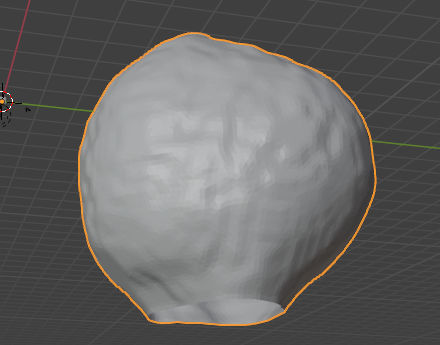

The mesh has two holes as the embryo does not fully fit into the microscope field of view.

## Surface reconstruction from a point cloud

As a first step, we'll have to extract a point cloud from our segmentation. There are several ways you could do this, for instance, moving along an axis more or less transversal to the surface and looking for a local maximum in the segmentation intensity. We'll do the simplest possible thing and consider all points with a segmentation intensity greater than a threshold (this is generally a bad idea). 
We then simplify the point cloud (reduce the number of points), and apply the surface reconstruction algorithm.

You can also do this graphically in the MeshLab GUI, using the "Surface reconstruction" filters.

In [ ]:
# let's load the segmentation 
segmentation = tcio.read_h5(f"reconstruction_example/zebrafish_probabilities.h5")[0]

# now let's select all the points where the segmentation probability exceeds some threshold
threshold = 0.4
segmentation_binary = segmentation>threshold
segmentation_binary = ndimage.binary_erosion(segmentation_binary, iterations=1)
points = np.stack(np.where(segmentation_binary), axis=-1)

<matplotlib.image.AxesImage>

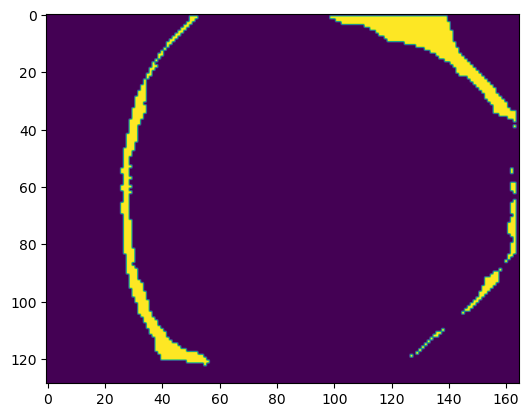

In [ ]:
zslice = 80
plt.imshow(segmentation_binary[zslice,:,:])

In [ ]:
# a point cloud is simply a mesh with no faces

point_cloud = tcmesh.ObjMesh(vertices=points, faces=[])
point_cloud_pymeshlab = intmsl.convert_to_pymeshlab(point_cloud)

In [ ]:
# let's create a pymeshlab instance and add out point cloud to it

# There are three relevant filters we will use:
# generate_simplified_point_cloud - reduce number of points in point cloud
# compute_normal_for_point_clouds - estimate normals for point cloid. This is required for the next step
# generate_surface_reconstruction_screened_poisson - Surface reconstruction by Poisson reconstruction

ms = pymeshlab.MeshSet()
ms.add_mesh(point_cloud_pymeshlab)

ms.generate_simplified_point_cloud(samplenum=1000)
ms.compute_normal_for_point_clouds(k=20, smoothiter=2)
ms.generate_surface_reconstruction_screened_poisson(depth=8, fulldepth=5,)

ms.meshing_isotropic_explicit_remeshing(iterations=10, targetlen=pymeshlab.PercentageValue(1))

mesh_reconstructed = intmsl.convert_from_pymeshlab(ms.current_mesh())

In [ ]:
mesh_reconstructed.faces.shape

(24974, 3)

In [ ]:
mesh_reconstructed.write_obj("reconstruction_example/zebrafish_mesh_reconstructed.obj")

In [ ]:
# we also provide a simple wrapper for this procedure

mesh_reconstructed = tcremesh_pymeshlab.reconstruct_poisson(points, samplenum=1000,
                                                            reconstruc_args={"depth": 8, "fulldepth": 5})
mesh_reconstructed.faces.shape

(7090, 3)

Compare the result of the Poisson reconstruction and marching cubes methods in blender!
The Poisson reconstruction gives us a mesh of the _outer_ surface of the embryo.
